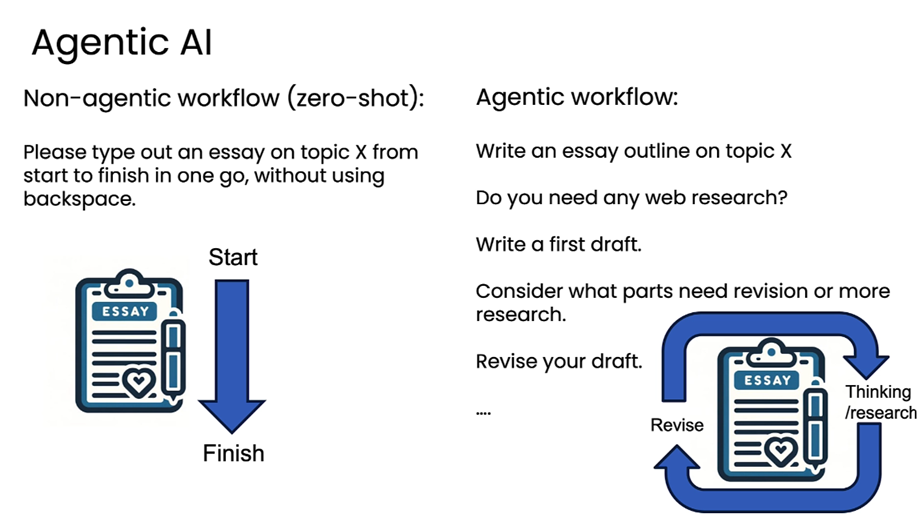

# What are AI Agents?
AI Agents are systems that enable Large Language Models(LLMs) to perform actions by extending their capabilities by giving LLMs access to tools and knowledge.

**Large Language Models** - The concept of agents existed before the creation of LLMs. The advantage of building AI Agents with LLMs is their ability to interpret human language and data. This ability enables LLMs to interpret environmental information and define a plan to change the environment.

**Perform Actions** - Outside of AI Agent systems, LLMs are limited to situations where the action is generating content or information based on a user's prompt. Inside AI Agent systems, LLMs can accomplish tasks by interpreting the user's request and using tools that are available in their environment.

**Access To Tools** - What tools the LLM has access to is defined by 1) the environment it's operating in and 2) the developer of the AI Agent. For our travel agent example, the agent's tools are limited by the operations available in the booking system, and/or the developer can limit the agent's tool access to flights.

**Memory+Knowledge** - Memory can be short-term in the context of the conversation between the user and the agent. Long-term, outside of the information provided by the environment, AI Agents can also retrieve knowledge from other systems, services, tools, and even other agents. In the travel agent example, this knowledge could be the information on the user's travel preferences located in a customer database.



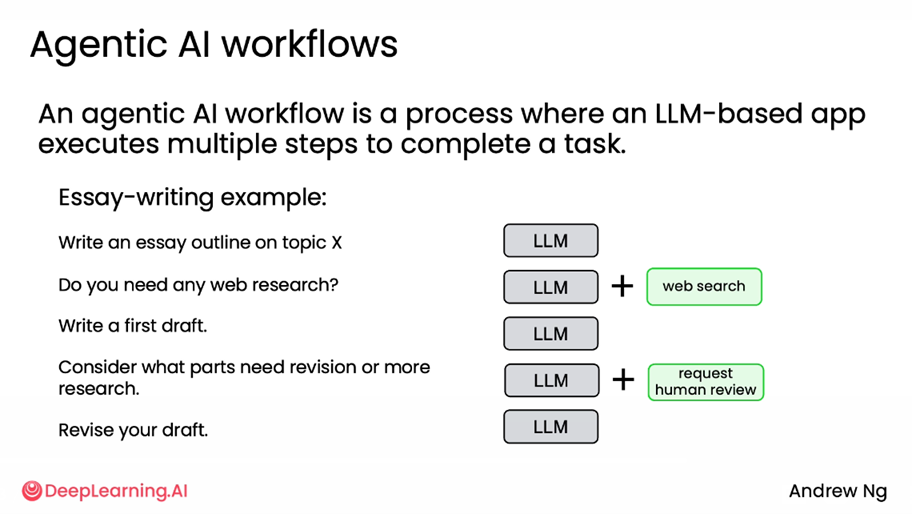

## Different types of agents
Let's look at some specific agent types and how they would be applied to a travel booking AI agent.

| Agent | Type | Description |
|----------|--------------|----------|
| Simple Reflex Agents | Perform immediate actions <br> based on **predefined rules**. | 		Travel agent interprets the context <br> of the email and **forwards** |
| Model-Based Reflex Agents |Perform actions based on a model<br>  of the world and **changes** to that model. | Travel agent prioritizes routes with <br> **significant price changes** based on<br>  access to historical pricing data. |
|Goal-Based Agents | Create plans to achieve **specific<br>  goals** by interpreting the goal <br> and determining actions to reach it.	| Travel agent books a journey by <br> determining necessary **travel <br> arrangements** (car, public transit, flights) <br> from the current location to the destination. |
| Utility-Based Agents	| Consider preferences and **weigh <br> tradeoffs numerically** to determine<br>  how to achieve goals.	| Travel agent **maximizes utility** by weighing <br> convenience vs. cost when booking travel. |
| Learning Agents	| **Improve** over time by responding to<br>  feedback and adjusting actions accordingly.| Travel agent improves by using **customer<br>  feedback** from post-trip surveys to make <br> adjustments to future bookings. |
| Hierarchical Agents	 | Feature **multiple agents** in a tiered system, <br> with higher-level agents breaking tasks <br> into subtasks for lower-level agents to complete. | Travel agent cancels a trip by dividing <br> the task into **subtasks** (for example, <br> canceling specific bookings) and having <br> lower-level agents complete them,<br>  reporting back to the higher-level agent. |
| Multi-Agent Systems (MAS) |	Agents complete tasks **independently**, <br> either cooperatively or competitively. |	**Cooperative**: Multiple agents book specific <br> travel services such as hotels, flights,<br>  and entertainment. <br> **Competitive**: Multiple agents manage and <br> compete over a shared hotel booking <br> calendar to book customers into the hotel. |

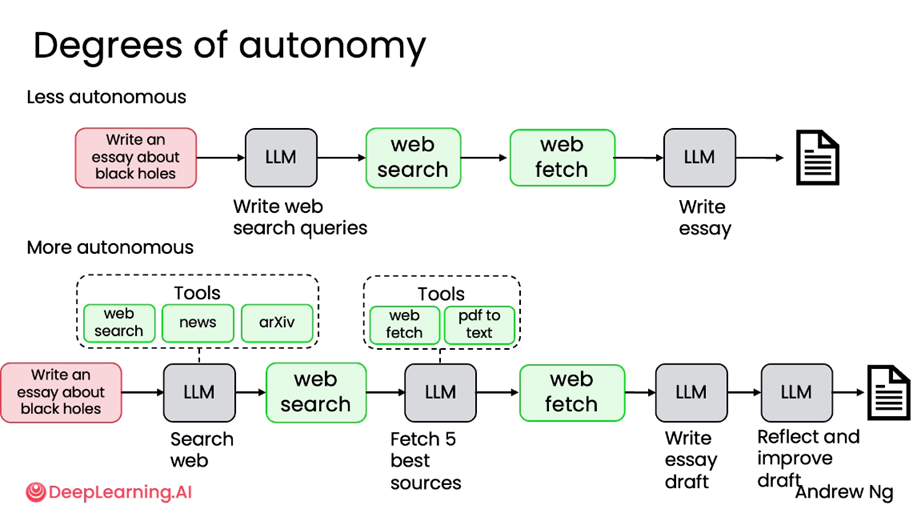


## When to Use AI Agents?

- Open-Ended Problems - allowing the LLM to determine needed steps to complete a task because it can't always be hardcoded into a workflow.
- Multi-Step Processes - tasks that require a level of complexity in which the AI Agent needs to use tools or information over multiple turns instead of single shot retrieval.
- Improvement Over Time - tasks where the agent can improve over time by receiving feedback from either its environment or users in order to provide better utility.

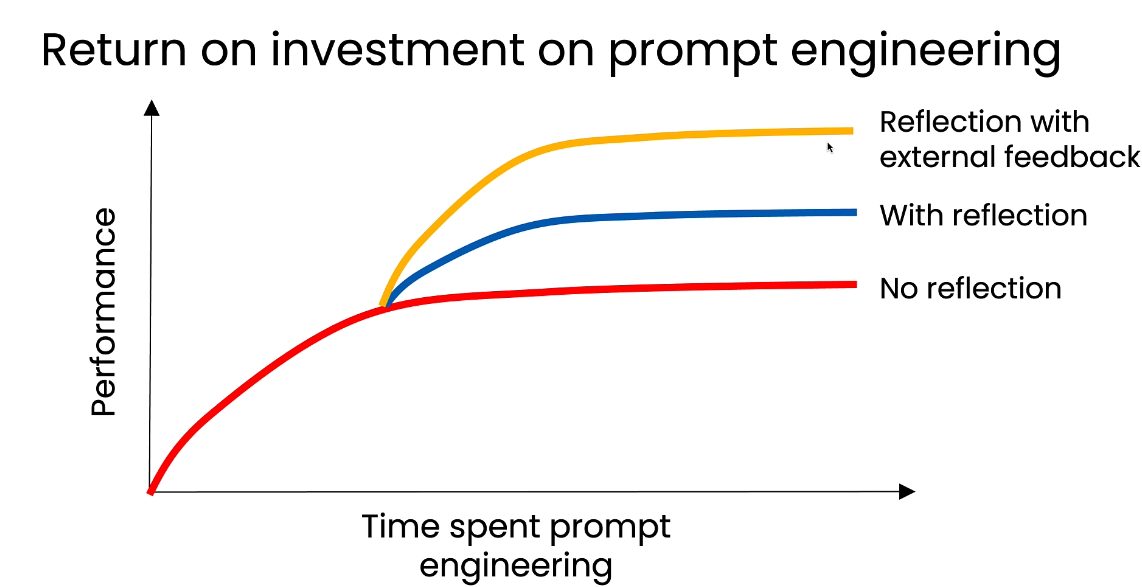

# Building a ReAct Agent from Scratch

In this tutorial where we'll build a **ReAct Agent from scratch**. This will give you a deep understanding of how agents actually work.

## What You'll Learn

- The core principles of ReAct (Reasoning + Acting)
- How to implement an agent loop manually
- How to parse agent outputs and execute tools
- How to build a complete reasoning system

## Requirements

This notebook runs on **CPU** with open-source models and **no external dependencies** beyond transformers and Wikipedia.

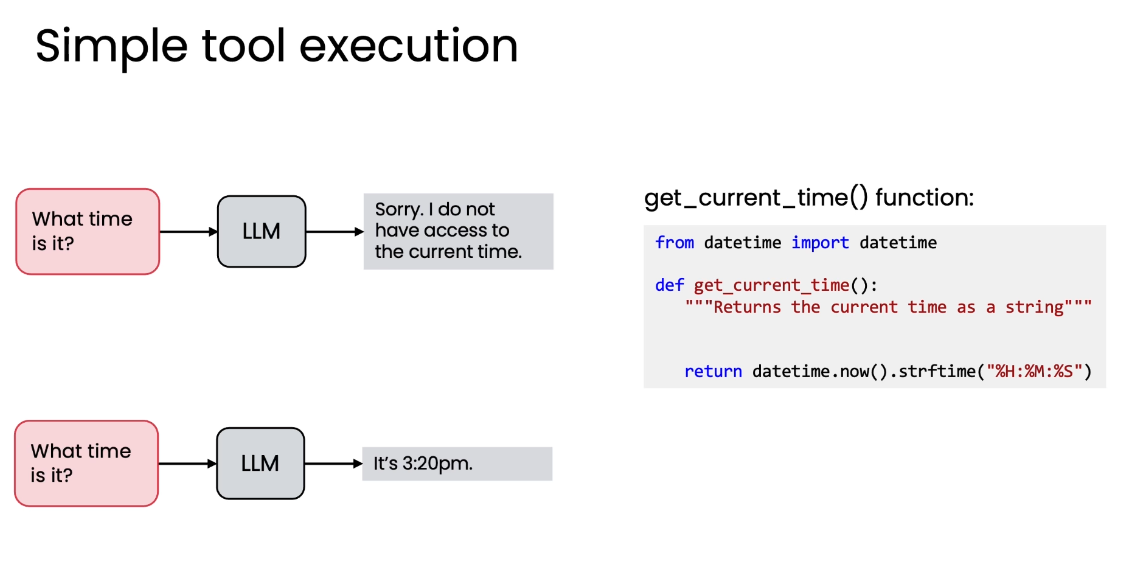

---

## 📚 Part 1: Understanding ReAct Agents

### What is ReAct?

**ReAct** = **Reasoning** + **Acting**

A ReAct agent follows this loop:

```
1. Thought: Reason about what to do next
2. Action: Choose a tool to use
3. Action Input: Provide input to the tool
4. Observation: Receive the tool's output
5. Repeat until you have the final answer
```

### Example

**Question**: "What is the population of France squared?"

**Agent Process**:
```
Thought: I need to find France's population first
Action: Wikipedia
Action Input: France population
Observation: France has approximately 68 million people

Thought: Now I need to square this number
Action: Calculator
Action Input: 68000000 ** 2
Observation: 4624000000000000

Thought: I now know the final answer
Final Answer: 4,624,000,000,000,000
```

### Our Implementation

We'll build:
1. **Tools**: Wikipedia search and Python calculator
2. **Prompt Template**: Instructions for the LLM
3. **Parser**: Extract actions from LLM output
4. **Agent Loop**: Orchestrate the reasoning process

The LLM will choose whether to use the tool or not.

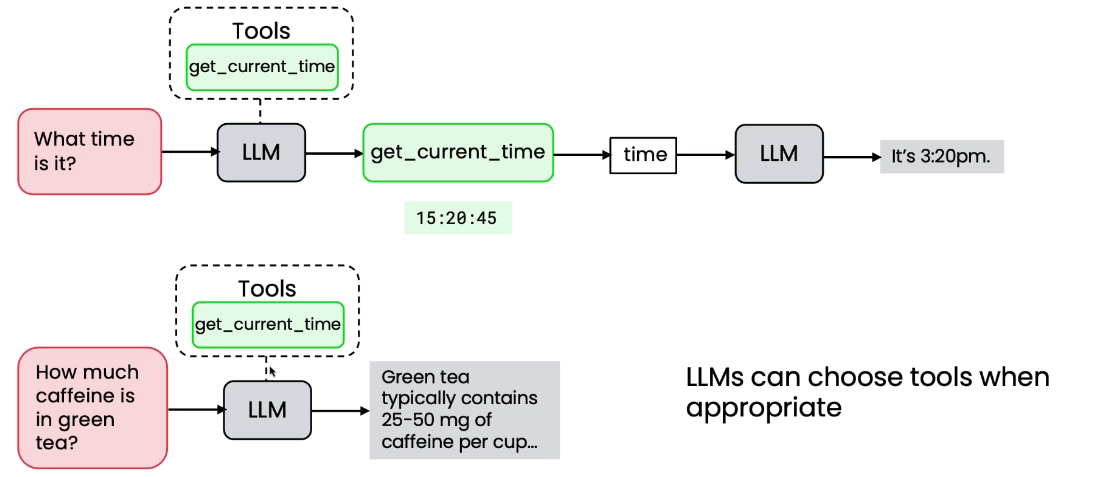

Depending on the application we are building, we will have to build multiple tools.

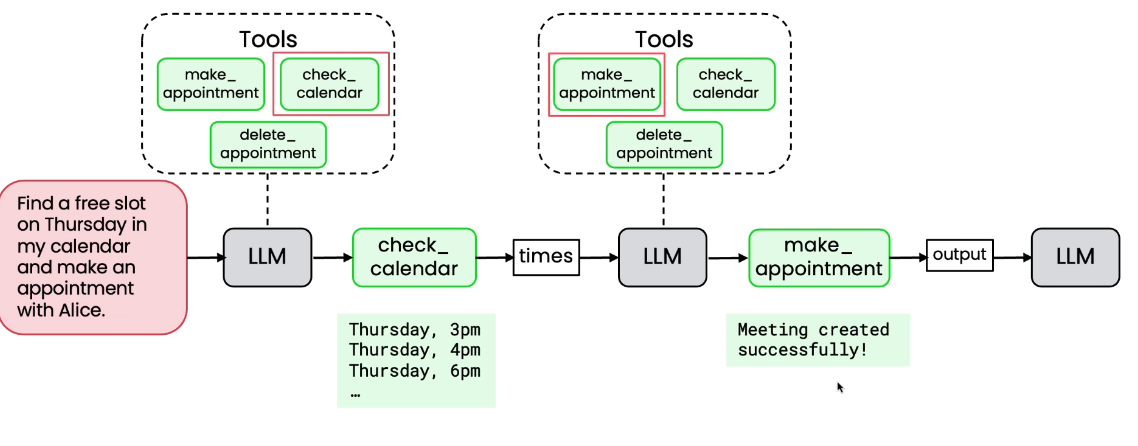

---

## 🛠️ Part 2: Installation

We only need a few libraries: transformers for the LLM and wikipedia for information retrieval.

In [ ]:
# Install required packages
!pip install -q transformers torch wikipedia

---

## 🤖 Part 3: Loading the Language Model

We'll use **FLAN-T5** as our reasoning engine. This model will:
- Analyze the question
- Decide which tools to use
- Generate thoughts and actions

We're using `flan-t5-base` for speed on CPU.

In [ ]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

# Model configuration
MODEL_NAME = "google/flan-t5-base"

print(f"📥 Loading {MODEL_NAME}...")
print("   This may take a few minutes on first run.\n")

## Check the model card and fill in
# Load model and tokenizer
tokenizer = __
model = __

print("✅ Model loaded successfully!")
print(f"   Model: {MODEL_NAME}")

### Helper Function: Generate Text

Let's create a helper function to generate text from the model.

In [ ]:
def generate_text(prompt, max_length=512):
    """
    Generate text from the model given a prompt.
    """
    inputs = tokenizer(prompt, return_tensors="pt", max_length=1024, truncation=True)
    outputs = model.generate(
        inputs.input_ids,
        max_length=max_length,
        num_beams=1,
        do_sample=False,
        early_stopping=True
    )
    return tokenizer.decode(outputs[0], skip_special_tokens=True)

# Test the model
test_response = generate_text("What is the capital of France?")
print(f"Test: What is the capital of France?")
print(f"Answer: {test_response}")

What's happening? How can we fix it?

In [ ]:
test_response = generate_text("What is the population of France squared?")
print(f"Test: What is the population of France squared?")
print(f"Answer: {test_response}")

---

## 🔧 Part 4: Building the Tools

Tools are functions that the agent can call. Each tool has:
- A **name**
- A **description** (tells the LLM when to use it)
- A **function** (the actual implementation)

Let's create two tools: Wikipedia and Calculator.

In [ ]:
import wikipedia
import re

# Tool 1: Wikipedia Search
def wikipedia_search(query):
    """
    Search Wikipedia and return a summary.
    """
    try:
        # Search Wikipedia and get the summary
        result = wikipedia.summary(query, sentences=3)
        return result
    except wikipedia.exceptions.DisambiguationError as e:
        # If multiple results, return the first option
        return wikipedia.summary(e.options[0], sentences=3)
    except wikipedia.exceptions.PageError:
        return "Page not found. Try a different search term."
    except Exception as e:
        return f"Error: {str(e)}"

In [ ]:
# Tool 2: Python Calculator
def calculator(expression):
    """
    Evaluate a Python mathematical expression.
    """
    try:
        # Use eval with a restricted namespace for safety
        result = eval(expression, {"__builtins__": {}}, {})
        return str(result)
    except Exception as e:
        return f"Error evaluating expression: {str(e)}"

In [ ]:
# Define available tools
TOOLS = {
    "Wikipedia": {
        "function": wikipedia_search,
        "description": "Useful for finding factual information about people, places, events, and general knowledge. Input should be a search query."
    },
    "Calculator": {
        "function": calculator,
        "description": "Useful for mathematical calculations. Input should be a valid Python mathematical expression (e.g., '2 + 2', '68000000 ** 2')."
    }
}

In [ ]:
for name, tool in TOOLS.items():
    print(f"\n  📌 {name}")
    print(f"     {tool['description']}")

### 🧪 Testing the Tools

Let's test each tool to make sure they work correctly.

In [ ]:
# Test Wikipedia
print("Testing Wikipedia Tool:")
print("="*50)
result = wikipedia_search("France population")
print(result)
print()

In [ ]:
# Test Calculator
print("Testing Calculator Tool:")
print("="*50)
result = calculator("68000000 ** 2")
print(f"68000000 ** 2 = {result}")

---

## 📝 Part 5: Creating the ReAct Prompt Template

The prompt is crucial! It tells the model:
- What tools are available
- How to format its responses
- The reasoning pattern to follow

We'll use a structured format that the model can follow.

In [ ]:
def create_react_prompt(question, tools, history=""):
    """
    Create a ReAct-style prompt for the LLM.

    Args:
        question: The user's question
        tools: Dictionary of available tools
        history: Previous thoughts, actions, and observations
    """
    # Build tool descriptions
    tool_descriptions = ""
    for name, tool in tools.items():
        tool_descriptions += f"- {name}: {tool['description']}\n"

    prompt = f"""Answer the following question using the available tools. Follow this format:

Thought: [Your reasoning about what to do next]
Action: [Tool name to use: Wikipedia or Calculator]
Action Input: [Input for the tool]

You will receive an Observation with the tool's output. Then continue reasoning.

When you have enough information, respond with:
Thought: I now know the final answer
Final Answer: [Your answer]

Available Tools:
{tool_descriptions}

Question: {question}

{history}

Thought:"""

    return prompt

# Test the prompt
test_prompt = create_react_prompt("What is the population of France squared?", TOOLS)
print("Sample Prompt:")
print("="*70)
print(test_prompt)
print("="*70)

---

## 🔍 Part 6: Building the Action Parser

We need to parse the model's output to extract:
- Thoughts
- Actions
- Action Inputs
- Final Answers

This is a critical component of the agent!

In [ ]:
def parse_action(text):
    """
    Parse the model's output to extract action and action input.

    Returns:
        dict with 'thought', 'action', 'action_input', and 'final_answer'
    """
    result = {
        'thought': None,
        'action': None,
        'action_input': None,
        'final_answer': None
    }

    # Check for final answer
    if "Final Answer:" in text:
        final_match = re.search(r"Final Answer:\s*(.+)", text, re.IGNORECASE)
        if final_match:
            result['final_answer'] = final_match.group(1).strip()
            return result

    # Extract thought
    thought_match = re.search(r"Thought:\s*(.+?)(?=\n|Action:|$)", text, re.IGNORECASE | re.DOTALL)
    if thought_match:
        result['thought'] = thought_match.group(1).strip()

    # Extract action
    action_match = re.search(r"Action:\s*(.+?)(?=\n|$)", text, re.IGNORECASE)
    if action_match:
        result['action'] = action_match.group(1).strip()

    # Extract action input
    input_match = re.search(r"Action Input:\s*(.+?)(?=\n|$)", text, re.IGNORECASE | re.DOTALL)
    if input_match:
        result['action_input'] = input_match.group(1).strip()

    return result

# Test the parser
test_output = """I need to find the population first
Action: Wikipedia
Action Input: France population"""

parsed = parse_action(test_output)
print("Testing Parser:")
print(f"Input: {test_output}")
print(f"\nParsed:")
print(f"  Thought: {parsed['thought']}")
print(f"  Action: {parsed['action']}")
print(f"  Action Input: {parsed['action_input']}")

---

## 🔄 Part 7: Implementing the Agent Loop

Now we'll build the main agent loop that:
1. Generates a thought and action
2. Executes the action using a tool
3. Observes the result
4. Repeats until we have a final answer

This is the heart of the ReAct agent!

In [ ]:
def run_agent(question, tools, max_iterations=5, verbose=True):
    """
    Run the ReAct agent loop.

    Args:
        question: The question to answer
        tools: Dictionary of available tools
        max_iterations: Maximum number of reasoning steps
        verbose: Whether to print the reasoning process

    Returns:
        The final answer
    """
    history = ""

    if verbose:
        print(f"\n{'='*70}")
        print(f"Question: {question}")
        print(f"{'='*70}\n")

    for iteration in range(max_iterations):
        if verbose:
            print(f"\n--- Iteration {iteration + 1} ---\n")

        # Generate the prompt
        prompt = create_react_prompt(question, tools, history)

        # Get model response
        response = generate_text(prompt, max_length=256)

        if verbose:
            print(f"Model Output: {response}\n")

        # Parse the response
        parsed = parse_action(response)

        # Check for final answer
        if parsed['final_answer']:
            if verbose:
                print(f"\n{'='*70}")
                print(f"✅ Final Answer: {parsed['final_answer']}")
                print(f"{'='*70}\n")
            return parsed['final_answer']

        # Display thought
        if parsed['thought'] and verbose:
            print(f"💭 Thought: {parsed['thought']}")

        # Execute action
        if parsed['action'] and parsed['action_input']:
            action_name = parsed['action']
            action_input = parsed['action_input']

            if verbose:
                print(f"🔧 Action: {action_name}")
                print(f"📥 Action Input: {action_input}")

            # Execute the tool
            if action_name in tools:
                observation = tools[action_name]['function'](action_input)

                if verbose:
                    print(f"👁️ Observation: {observation}")

                # Add to history
                history += f"Thought: {parsed['thought'] or response}\n"
                history += f"Action: {action_name}\n"
                history += f"Action Input: {action_input}\n"
                history += f"Observation: {observation}\n\n"
            else:
                if verbose:
                    print(f"❌ Unknown action: {action_name}")
                history += f"Error: Unknown action '{action_name}'\n\n"
        else:
            # If we can't parse an action, try to guide the model
            if verbose:
                print("⚠️ Could not parse action. Adding guidance...")
            history += f"Previous response: {response}\n"
            history += "Please provide your next thought and action in the correct format.\n\n"

    # Max iterations reached
    if verbose:
        print(f"\n⚠️ Max iterations ({max_iterations}) reached without finding answer.")
    return "Unable to determine answer within iteration limit."

print("✅ Agent loop implemented!")

---

## 🚀 Part 8: Running the Agent

Now let's put it all together and run our agent!

We'll ask: **"What is the population of France squared?"**

Watch as the agent:
1. Searches Wikipedia for France's population
2. Uses the calculator to square the number
3. Provides the final answer

**Note**: This may take 2-5 minutes on CPU. Be patient!

In [ ]:
# Run the agent
question = "What is the population of France squared?"

answer = run_agent(
    question=question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)

---

## 🔍 Part 9: Understanding What Happened

Let's break down the agent's reasoning process:

### The ReAct Loop in Action

1. **Iteration 1**:
   - **Thought**: "I need to find the population of France"
   - **Action**: Wikipedia
   - **Observation**: Gets population data from Wikipedia

2. **Iteration 2**:
   - **Thought**: "Now I need to square this number"
   - **Action**: Calculator
   - **Observation**: Gets the squared result

3. **Final Step**:
   - **Thought**: "I now know the final answer"
   - **Final Answer**: The squared population

### Key Components We Built

1. **Tools**: Modular functions (Wikipedia, Calculator)
2. **Prompt Engineering**: Structured instructions for the LLM
3. **Parser**: Extracts structured data from free text
4. **Agent Loop**: Orchestrates the reasoning process

### Why This Works

- **Structured Format**: The prompt guides the model to follow a pattern
- **Iterative Refinement**: Each observation informs the next thought
- **Tool Integration**: The agent can access external capabilities
- **Transparency**: We can see every step of the reasoning

---

## 🎯 Part 10: Try Your Own Questions!

Now it's your turn! Try different questions that require reasoning and tool use.

### Good Questions to Try:

- "What is the area of Germany multiplied by 3?"
- "What is 100 plus the population of Tokyo in millions?"
- "How many years ago was Albert Einstein born?" (requires current year calculation)

### Tips:

1. **Keep it simple**: Smaller models work better with straightforward queries
2. **Two-step problems**: Questions requiring retrieval + calculation work best
3. **Be patient**: CPU inference takes time

In [ ]:
# Try your own question!
your_question = "What is the area of Germany multiplied by 3?"

answer = run_agent(
    question=your_question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)

---

## 🛠️ Part 11: Adding More Tools (Optional)

One of the best parts of building from scratch is how easy it is to add new tools!

Let's add a **Current Date** tool as an example.

In [ ]:
from datetime import datetime

# New tool: Get current date
def get_current_date(query=""):
    """
    Get the current date and year.
    """
    now = datetime.now()
    return f"Today is {now.strftime('%B %d, %Y')}. The current year is {now.year}."

# Add to tools
TOOLS["CurrentDate"] = {
    "function": get_current_date,
    "description": "Get the current date and year. Useful for calculating time-based questions."
}

print("✅ New tool added!")
print(f"\nAvailable tools: {', '.join(TOOLS.keys())}")

# Test with a time-based question
time_question = "How many years ago was the year 2000?"

answer = run_agent(
    question=time_question,
    tools=TOOLS,
    max_iterations=5,
    verbose=True
)